<h1 align="center"><font size="5">RESTRICTED BOLTZMANN MACHINES</font></h1>
<h3>Introduction</h3>
<b>Restricted Boltzmann Machine (RBM):</b>  RBMs are shallow neural nets that learn to reconstruct data by themselves in an unsupervised fashion.  


<h4>Why are RBMs important?</h4>
It can automatically extract <b>meaningful</b> features from a given input.


<h4>How does it work?</h4>
RBM is a 2 layer neural network. Simply, RBM takes the inputs and translates those into a set of binary values that represents them in the hidden layer. Then, these numbers can be translated back to reconstruct the inputs. Through several forward and backward passes, the RBM will be trained, and a trained RBM can reveal which features are the most important ones when detecting patterns.   


<h4>What are the applications of RBM?</h4>
RBM is useful for <a href='http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf'>  Collaborative Filtering</a>, dimensionality reduction, classification, regression, feature learning, topic modeling and even <b>Deep Belief Networks</b>.



<h4>Is RBM a generative or Discriminative model?</h4>
RBM is a generative model. Let me explain it by first, see what is different between discriminative and generative models: 

<b>Discriminative:</b> Consider a classification problem in which we want to learn to distinguish between Sedan cars (y = 1) and SUV cars (y = 0), based on some features of cars. Given a training set, an algorithm like logistic regression tries to find a straight line—that is, a decision boundary—that separates the suv and sedan.  
<b>Generative:</b> looking at cars, we can build a model of what Sedan cars look like. Then, looking at SUVs, we can build a separate model of what SUV cars look like. Finally, to classify a new car, we can match the new car against the Sedan model, and match it against the SUV model, to see whether the new car looks more like the SUV or Sedan. 

Generative Models specify a probability distribution over a dataset of input vectors. We can do both supervise and unsupervised tasks with generative models:
<ul>
    <li>In an unsupervised task, we try to form a model for P(x), where P is the probability given x as an input vector.</li>
    <li>In the supervised task, we first form a model for P(x|y), where P is the probability of x given y(the label for x). For example, if y = 0 indicates whether a car is a SUV or y = 1 indicates indicate a car is a Sedan, then p(x|y = 0) models the distribution of SUVs’ features, and p(x|y = 1) models the distribution of Sedans’ features. If we manage to find P(x|y) and P(y), then we can use <code>Bayes rule</code> to estimate P(y|x), because: $$p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$</li>
</ul>
Now the question is, can we build a generative model, and then use it to create synthetic data by directly sampling from the modeled probability distributions? Lets see. 

In [26]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
from utils import tile_raster_images


<a id="ref1"></a>
<h3>Initialization</h3>

First we have to load the utility file which contains different utility functions that are not connected
in any way to the networks presented in the tutorials, but rather help in
processing the outputs into a more understandable way.

In [20]:
import urllib.request
with urllib.request.urlopen("http://deeplearning.net/tutorial/code/utils.py") as url:
    response = url.read()
target = open("utils.py", 'w')
target.write(response.decode('utf-8'))
target.close()

<a id="ref2"></a>
<h3>RBM layers</h3>

An RBM has two layers. The first layer of the RBM is called the <b>visible</b> (or input layer). Imagine that our toy example, has only vectors with 7 values, so the visible layer must have j=7 input nodes. 
The second layer is the <b>hidden</b> layer, which possesses i neurons in our case. Each hidden node can have either 0 or 1 values (i.e., si = 1 or si = 0) with a probability that is a logistic function of the inputs it receives from the other j visible units, called for example, p(si = 1). For our toy sample, we'll use 2 nodes in the hidden layer, so i = 2.

<center><img src="https://ibm.box.com/shared/static/eu26opvcefgls6vnwuo29uwp0nudmokh.png" alt="RBM Model" style="width: 400px;"></center>

     

Each node in the first layer also has a <b>bias</b>. We will denote the bias as “v_bias” for the visible units. The <b>v_bias</b> is shared among all visible units.

Here we define the <b>bias</b> of second layer as well. We will denote the bias as “h_bias” for the hidden units. The <b>h_bias</b> is shared among all hidden units

In [21]:
v_bias = tf.placeholder(tf.float32, [7])
h_bias = tf.placeholder(tf.float32, [2])

We have to define weights among the input layer and hidden layer nodes. In the weight matrix, the number of rows are equal to the input nodes, and the number of columns are equal to the output nodes. Let <b>W</b> be the Tensor of 7x2 (7 - number of visible neurons, 2 - number of hidden neurons) that represents weights between neurons. 

In [22]:
W = tf.constant(np.random.normal(size=(7,2)).astype(np.float32))

<a id="ref3"></a>
<h3>What RBM can do after training?</h3>
Think RBM as a model that has been trained based on images of a dataset of many SUV and Sedan cars. Also, imagine that the RBM network has only two hidden nodes, one for the weight and, and one for the size of cars, which in a sense, their different configurations represent different cars, one represent SUV cars and one for Sedan. In a training process, through many forward and backward passes, RBM adjust its weights to send a stronger signal to either the SUV node (0, 1) or the Sedan node (1, 0) in the hidden layer, given the pixels of images. Now, given a SUV in hidden layer, which distribution of pixels should we expect? RBM can give you 2 things. First, it encodes your images in hidden layer. Second, it gives you the probability of observing a case, given some hidden values.


<h3>How to inference?</h3>

RBM has two phases:
<ul>
    <li>Forward Pass</li>  
    <li>Backward Pass or Reconstruction</li>
</ul>

<b>Phase 1) Forward pass:</b>  Input one training sample (one image) <b>X</b> through all visible nodes, and pass it to all hidden nodes. Processing happens in each node in the hidden layer. This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer). At the hidden layer's nodes, <b>X</b> is multiplied by a <b>$W_{ij}$</b> and added to <b>h_bias</b>. The result of those two operations is fed into the sigmoid function, which produces the node’s output, $p({h_j})$, where j is the unit number. 


$p({h_j})= \sigma(\sum_i w_{ij} x_i)$, where $\sigma()$ is the logistic function.


Now lets see what $p({h_j})$ represents. In fact, it is the probabilities of the hidden units. And, all values together are called <b>probability distribution</b>. That is, RBM uses inputs x to make predictions about hidden node activations. For example, imagine that the values of $h_p$ for the first training item is [0.51 0.84]. It tells you what is the conditional probability for each hidden neuron to be at Phase 1): 
<ul>
    <li>p($h_{1}$ = 1|V) = 0.51</li>
    <li>($h_{2}$ = 1|V) = 0.84</li>  
</ul>

As a result, for each row in the training set, <b>a vector/tensor</b> is generated, which in our case it is of size [1x2], and totally n vectors ($p({h})$=[nx2]). 

We then turn unit $h_j$ on with probability $p(h_{j}|V)$, and turn it off with probability $1 - p(h_{j}|V)$.

Therefore, the conditional probability of a configuration of h given v (for a training sample) is:

$$p(\mathbf{h} \mid \mathbf{v}) = \prod_{j=0}^H p(h_j \mid \mathbf{v})$$

Now, sample a hidden activation vector <b>h</b> from this probability distribution $p({h_j})$. That is, we sample the activation vector from the probability distribution of hidden layer values. 

Before we go further, let's look at a toy example for one case out of all input. Assume that we have a trained RBM, and a very simple input vector such as [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], lets see what would be the output of forward pass:

In [23]:
sess = tf.Session()
X = tf.constant([[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
v_state = X
print ("Input: ", sess.run(v_state))

h_bias = tf.constant([0.1, 0.1])
print ("hb: ", sess.run(h_bias))
print("w: ", sess. run(W))

# Calculate the probabilities of turning the hidden units on:
h_prob = tf.nn.sigmoid(tf.matmul(v_state, W) + h_bias)  # probabilities of the hidden units
print("p(h|v):", sess.run(h_prob))

# Draw samples from the distribution:
h_state = tf.nn.relu(tf.sign((h_prob - tf.random_uniform(tf.shape(h_prob)))))  # states
print ("h0 states:", sess.run(h_state))

Input:  [[1. 0. 0. 1. 0. 0. 0.]]
hb:  [0.1 0.1]
w:  [[-0.7514235  -0.8791663 ]
 [-0.28117564  0.16334358]
 [-0.27579546  0.5040468 ]
 [-1.5482575  -0.08012632]
 [ 0.2532346  -0.8843167 ]
 [-0.63132674  0.08944929]
 [ 1.0734617  -0.3694611 ]]
p(h|v): [[0.09977913 0.29748717]]
h0 states: [[-0. -0.]]


<b>Phase 2) Backward Pass (Reconstruction):</b>
The RBM reconstructs data by making several forward and backward passes between the visible and hidden layers.

So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. h) play the role of input. That is, <b>h</b> becomes the input in the backward pass. The same weight matrix and visible layer biases are used to go through the sigmoid function. The produced output is a reconstruction which is an approximation of the original input.

In [15]:
vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1])
print("b: ", sess.run(vb))
v_prob = sess.run(tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(W)) +vb))
print("p(vi|h): ", v_prob)
v_state = tf.nn.relu(tf.sign(v_prob - tf.random_uniform(tf.shape(v_prob))))
print("v probability states: ", sess.run(v_state))

b:  [0.1 0.2 0.1 0.1 0.1 0.2 0.1]
p(vi|h):  [[0.62595683 0.30337462 0.40886927 0.4072919  0.613773   0.61941195
  0.6666215 ]]
v probability states:  [[-0. -0. -0.  1. -0. -0.  1.]]


RBM learns a probability distribution over the input, and then, after being trained, the RBM can generate new samples from the learned probability distribution. As you know, <b>probability distribution</b>, is a mathematical function that provides the probabilities of occurrence of different possible outcomes in an experiment.

The (conditional) probability distribution over the visible units v is given by

$p(\mathbf{v} \mid \mathbf{h}) = \prod_{i=0}^V p(v_i \mid \mathbf{h}),$


where,

$p(v_i \mid \mathbf{h}) = \sigma\left( a_i + \sum_{j=0}^H w_{ji} h_j \right)$

so, given current state of hidden units and weights, what is the probability of generating [1. 0. 0. 1. 0. 0. 0.] in reconstruction phase, based on the above <b>probability distribution</b> function?

In [16]:
inp = sess.run(X)
print(inp)
print(v_prob[0])
v_probability = 1
for elm, p in zip(inp[0], v_prob[0]):
    if elm == 1:
        v_probability *= p
    else:
        v_probability *= (1-p)
v_probability

[[1. 0. 0. 1. 0. 0. 0.]]
[0.62595683 0.30337462 0.40886927 0.4072919  0.613773   0.61941195
 0.6666215 ]


0.005144798346728329

How similar X and V vectors are? Of course, the reconstructed values most likely will not look anything like the input vector because our network has not trained yet. Our objective is to train the model in such a way that the input vector and reconstructed vector to be same. Therefore, based on how different the input values look to the ones that we just reconstructed, the weights are adjusted. 

<h2>MNIST</h2>


We will be using the MNIST dataset to practice the usage of RBMs. The following cell loads the MNIST dataset.

In [28]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [30]:
# dimension of the images
trX[1].shape

(784,)

MNIST images have 784 pixels, so the visible layer must have 784 input nodes.  For our case, we'll use 50 nodes in the hidden layer, so i = 50.

In [31]:
vb = tf.placeholder(tf.float32, [784])
hb = tf.placeholder(tf.float32, [50])

Let <b>W</b> be the Tensor of 784x50 (784 - number of visible neurons, 50 - number of hidden neurons) that represents weights between the neurons. 

In [32]:
W = tf.placeholder(tf.float32, [784, 50])

In [33]:
# visible layer
v0_state = tf.placeholder(tf.float32, [None, 784])

In [34]:
# hidden layer
h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb) #probabilities of the hidden units
h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob))))  # sample_h_given_X

Now, we define reconstruction part:

In [35]:
v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb)
v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random_uniform(tf.shape(v1_prob))))  #sample_v_given_h

<h3>What is objective function?</h3>

<b>Goal</b>: Maximize the likelihood of our data being drawn from that distribution

<b>Calculate error:</b>  
In each epoch, we compute the "error" as a sum of the squared difference between step 1 and step n,
e.g the error shows the difference between the data and its reconstruction.

<b>Note:</b> tf.reduce_mean computes the mean of elements across dimensions of a tensor.

In [36]:
err = tf.reduce_mean(tf.square(v0_state -v1_state))

Train the model:

Ok, lets assume that k=1, that is we just get one more step:

In [37]:
h1_prob = tf.nn.sigmoid(tf.matmul(v1_state, W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob))))  #sample_h_given_X

In [38]:
alpha = 0.01
W_Delta = tf.matmul(tf.transpose(v0_state), h0_prob) -tf.matmul(tf.transpose(v1_state), h1_prob)
update_w = W + alpha * W_Delta
update_vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
update_hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)

Let's start a session and initialize the variables:

In [39]:
cur_w = np.zeros([784, 50], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([50], np.float32)
prv_w = np.zeros([784, 50], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([50], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [40]:
# error of the first run
sess.run(err, feed_dict={v0_state: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48138088

Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction er

Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction er

Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction error: 0.080946
Epoch:0 reconstruction er

Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction er

Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction er

Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction error: 0.080946
Epoch:1 reconstruction er

Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction er

Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction error: 0.080946
Epoch:2 reconstruction er

Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction er

Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction er

Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction error: 0.080946
Epoch:3 reconstruction er

Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction er

Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction error: 0.080946
Epoch:4 reconstruction er

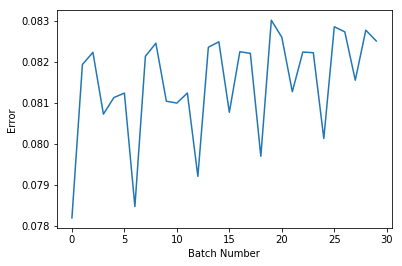

In [43]:
# Paramerters
epochs = 5
batchsize = 100
weights =[]
errors =[]

for epoch in range(epochs):
    for start, end in zip (range (0,len(trX), batchsize), range (batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0_state:batch, W:prv_w, vb:prv_vb, hb:prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start %10000 == 0:
            errors.append(sess.run(err, feed_dict={v0_state: trX, W:cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
        print ('Epoch:%d' %epoch, 'reconstruction error: %f' % error[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")    
plt.show()

In [44]:
uw = weights[-1].T
print (uw) # a weight matrix of shape (50,784)

[[-3.0483718  -2.958194   -2.8577435  ... -2.8832266  -2.9069629
  -2.993332  ]
 [-1.2830496  -1.3474869  -1.3104672  ... -1.3524854  -1.2854952
  -1.2607095 ]
 [-1.2664818  -1.4288273  -1.3570607  ... -1.2249041  -1.3724333
  -1.2475095 ]
 ...
 [-0.23135155 -0.26006448 -0.24508668 ... -0.23998684 -0.27001733
  -0.24659213]
 [-0.23712897 -0.26007968 -0.24503411 ... -0.2415035  -0.26142406
  -0.24712616]
 [-0.6674588  -0.64061064 -0.6528247  ... -0.6035145  -0.71268326
  -0.71157694]]
